<a href="https://colab.research.google.com/github/jesinthnalini001/Codes/blob/main/Automatic_Ticket_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the necessary libraries

In [2]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable = ["parser", "ner"])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

import locale
import gdown
locale.getpreferredencoding = lambda: "UTF-8"

import os

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Downloading the dataset

In [3]:
!wget --no-check-certificate 'https://docs.google.com/file/d/1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K' -O dataset

--2023-05-16 07:10:57--  https://docs.google.com/file/d/1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
Resolving docs.google.com (docs.google.com)... 108.177.120.113, 108.177.120.101, 108.177.120.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.120.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://docs.google.com/file/d/1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K/ [following]
--2023-05-16 07:10:57--  https://docs.google.com/file/d/1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K/
Reusing existing connection to docs.google.com:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://docs.google.com/file/d/1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K/edit [following]
--2023-05-16 07:10:58--  https://docs.google.com/file/d/1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K/edit
Reusing existing connection to docs.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘dataset’

dataset                 [ <=> 

### Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Download the JSON file from the Google Drive link
url = 'https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K'
output = '/content/complaints.json'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1Y4Yzh1uTLIBLnJq1_QvoosFx9giiR1_K
To: /content/complaints.json
100%|██████████| 83.4M/83.4M [00:00<00:00, 289MB/s]


'/content/complaints.json'

In [5]:
# Opening JSON file
with open(output) as fin:
    data = json.load(fin)

In [6]:
# Convert JSON data into a DataFrame
df = pd.json_normalize(data)

### Understanding the data and cleaning it

In [7]:
# Inspect the dataframe to understand the given data.
print(df.shape)
df.sample(5)

(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
51215,complaint-public-v2,complaint,1217247,0.0,None,91304,1217247,"Account opening, closing, or management",2015-01-29T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Web,2015-01-29T12:00:00-05:00,None,Checking account,Yes,,None,N/A
18160,complaint-public-v2,complaint,2569865,0.0,None,945XX,2569865,Problem with a purchase shown on your statement,2017-07-10T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-07-10T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,"Hi, I filed a dispute with chase bank on XX/XX...",Credit card company isn't resolving a dispute ...,Consent provided
2938,complaint-public-v2,complaint,1881275,0.0,None,33314,1881275,"Account opening, closing, or management",2016-04-15T12:00:00-05:00,FL,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2016-04-15T12:00:00-05:00,None,Checking account,Yes,,None,N/A
74387,complaint-public-v2,complaint,244877,0.0,None,90813,244877,Using a debit or ATM card,2013-01-18T12:00:00-05:00,CA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2013-01-22T12:00:00-05:00,None,Checking account,Yes,,None,N/A
57553,complaint-public-v2,complaint,2683347,0.0,None,None,2683347,"Other features, terms, or problems",2017-09-24T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-24T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,Chase changed my card without my authorization...,Problem with rewards from credit card,Consent provided


In [8]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


Changing column names to make them more understandable

In [9]:
df.columns = [re.sub("^_(source.)?", "", column_name) for column_name in df.columns]
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


Replace all the blanks with nan in the complaints columns and remove all rows of the dataframe containing nan in the complaints column

In [10]:
df["complaint_what_happened"] = df["complaint_what_happened"].apply(lambda x : np.nan if re.search("^[\s]*$", x) else x)
df = df[~(df["complaint_what_happened"].isnull())]
df.shape

(21072, 22)

### Prepare the text for topic modeling



Defining a function to clean the text - convert the text to lower case, remove text in square brackets, remove punctuation, remove words containing numbers

In [11]:
def cleaner(complaint) :
  complaint = complaint.lower()
  complaint = re.sub("\[.*?\]", "", complaint)
  complaint = "".join([char for char in complaint if char not in string.punctuation])
  complaint = re.sub("[^\s]*[\d]+[^\s]*", "", complaint)
  return complaint

complaints = df["complaint_what_happened"].apply(cleaner)

Defining a function that lemmatizes the text and extracts only NOUNS

In [12]:
def lemmatizer_posfilter(complaint) :
  doc = nlp(str(complaint))
  lemma_complaint = " ".join([token.lemma_ for token in doc])
  pos_filtered = " ".join([token.lemma_ for token in doc if token.pos_ == "NOUN"])
  return lemma_complaint, pos_filtered

lemma_pos = complaints.apply(lemmatizer_posfilter)
lemmatized_complaints = [lemma_complaint for lemma_complaint, pos_filtered_complaint in lemma_pos]
pos_filtered_complaints = [pos_filtered_complaint for lemma_complaint, pos_filtered_complaint in lemma_pos]

Creating a dataframe "df_clean" that holds the raw_complaints, initial_preprocessed_complaints, lemmatized_complaints and the pos_filtered_complaints

In [13]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
pd.set_option("max_colwidth", None)
df_clean = pd.DataFrame({"raw_complaints" : df["complaint_what_happened"], "initial_preprocessed_complaints" : complaints, "lemmatized_complaints" : lemmatized_complaints, "pos_filtered_complaints" : pos_filtered_complaints})
df_clean.reset_index(drop = True, inplace = True)
df_clean.sample(3)

,raw_complaints,initial_preprocessed_complaints,lemmatized_complaints,pos_filtered_complaints
13689,"Disputed debit card transaction with Chase Bank on or about XX/XX/2018 with a useless unhelpful individual with case number XXXX. This was for a purchase charged to the account in the amount of {$760.00} on or about XX/XX/2018 from merchant XXXX XXXX XXXX, as per the attached and per my phone call, this charge was paid for with alternate method of cash as per the attached paid receipt. Further, never signed for the purchase nor agreed/allowed the merchant to bill me for this purchase.",disputed debit card transaction with chase bank on or about with a useless unhelpful individual with case number xxxx this was for a purchase charged to the account in the amount of on or about from merchant xxxx xxxx xxxx as per the attached and per my phone call this charge was paid for with alternate method of cash as per the attached paid receipt further never signed for the purchase nor agreedallowed the merchant to bill me for this purchase,dispute debit card transaction with chase bank on or about with a useless unhelpful individual with case number xxxx this be for a purchase charge to the account in the amount of on or about from merchant xxxx xxxx xxxx as per the attach and per my phone call this charge be pay for with alternate method of cash as per the attach pay receipt far never sign for the purchase nor agreedallowe the merchant to bill I for this purchase,debit card transaction individual case number xxxx purchase account amount merchant phone call charge method cash receipt purchase merchant purchase
10177,I contacted my financial institution ( Chase Bank ) to report my stolen personal checks and to file a fraudulent check claim and Chase refused to send me an affidavit and failed to take any information regarding my case.,i contacted my financial institution chase bank to report my stolen personal checks and to file a fraudulent check claim and chase refused to send me an affidavit and failed to take any information regarding my case,I contact my financial institution chase bank to report my steal personal check and to file a fraudulent check claim and chase refuse to send I an affidavit and fail to take any information regard my case,institution bank check check claim chase affidavit information case
4798,"I opened an account online as part of a new account bonus offer that included a checking and savings offer. I opted for the checking only and the savings was also. I was supposed to get {$300.00} for opening a checking account and having direct deposit of {$250.00} or more in 2 consecutive months. I satisfied those qualifications and I called to check the status of the bonus and was told that there wasn't one and I needed to bring in the coupon to the branch. Since none of the disclosures were provided to me in any other method than on the screen online, they don't keep them online along with other account documentation, I had no way of finding the information regarding the 3 month old coupon. I was told by customers service to find any coupon, bring it to the branch and maybe they might be able to help if they are willing make an exception. Exception for what? Their systems not honoring a promise? More work on my end needs to be done because of a bait switch scenario it seems.",i opened an account online as part of a new account bonus offer that included a checking and savings offer i opted for the checking only and the savings was also i was supposed to get for opening a checking account and having direct deposit of or more in consecutive months i satisfied those qualifications and i called to check the status of the bonus and was told that there wasnt one and i needed to bring in the coupon to the branch since none of the disclosures were provided to me in any other method than on the screen online they dont keep them online along with other account documentation i had no way of finding the information regarding the month 

### Exploratory data analysis to get familiar with the data.





Visualising data according to the complaint's character length

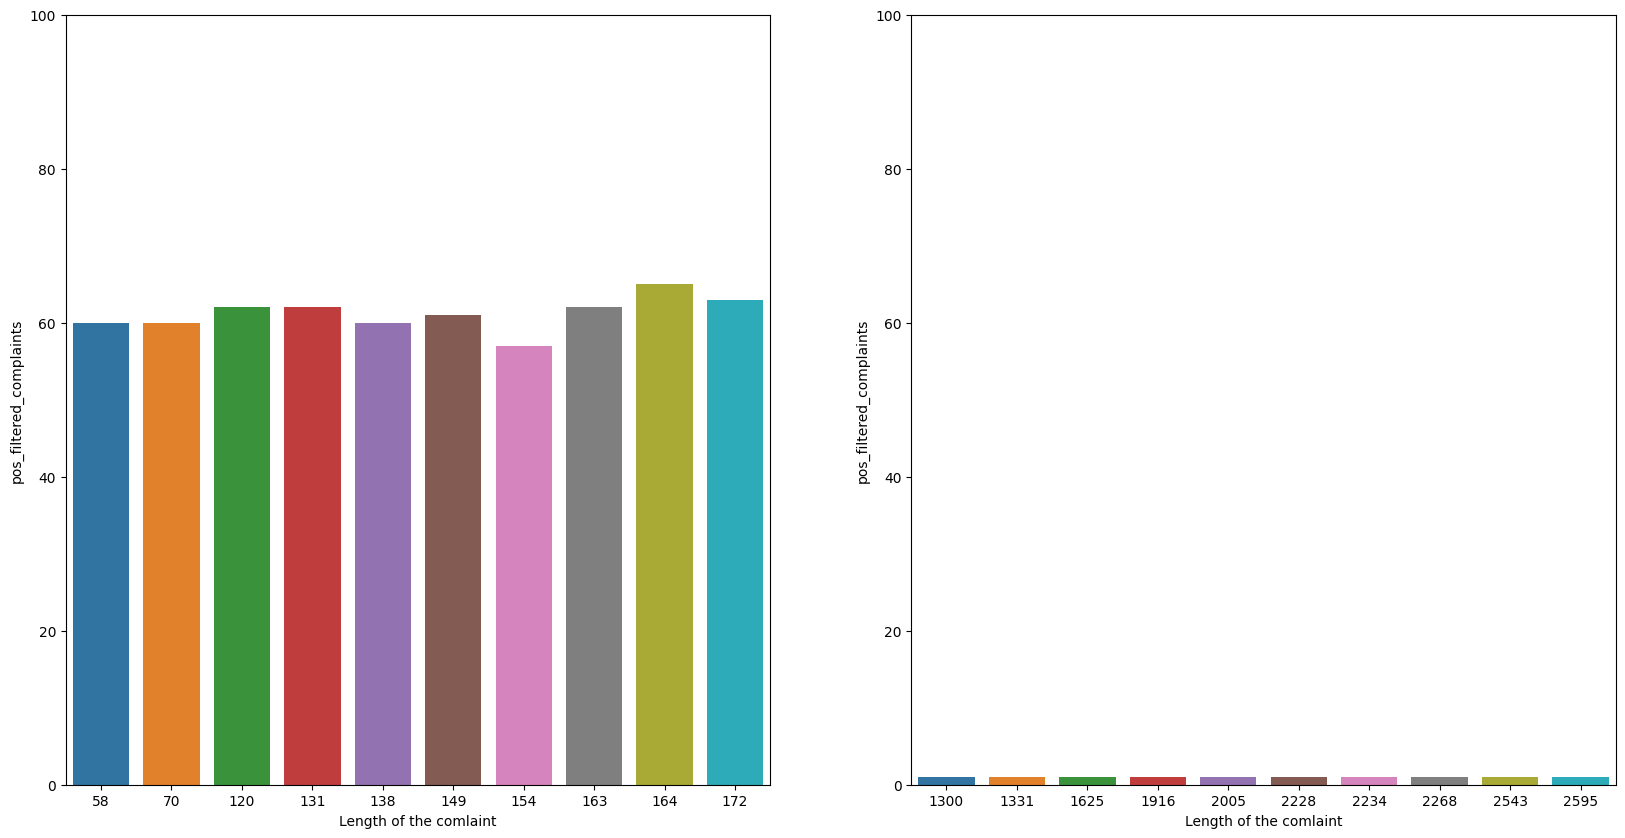

In [14]:
len_complaints = df_clean["pos_filtered_complaints"].apply(len).value_counts()
plt.figure(figsize = (20, 10))
plt.subplot(1, 2, 1)
plt.ylim((0, 100))
plt.xlabel("Length of the comlaint")
plt.ylabel("No of complaints")
sns.barplot(x = len_complaints.index[:10], y = len_complaints[:10])
plt.subplot(1, 2, 2)
plt.ylim((0, 100))
plt.xlabel("Length of the comlaint")
plt.ylabel("No of complaints")
sns.barplot(x = len_complaints.index[-10:], y = len_complaints[-10:])
plt.show()



*   Most of the complaints have a length in the range 50-200
*   There are very few complaints having lengths greater than 1000



Find the top 40 words by frequency among all the articles after processing the text.

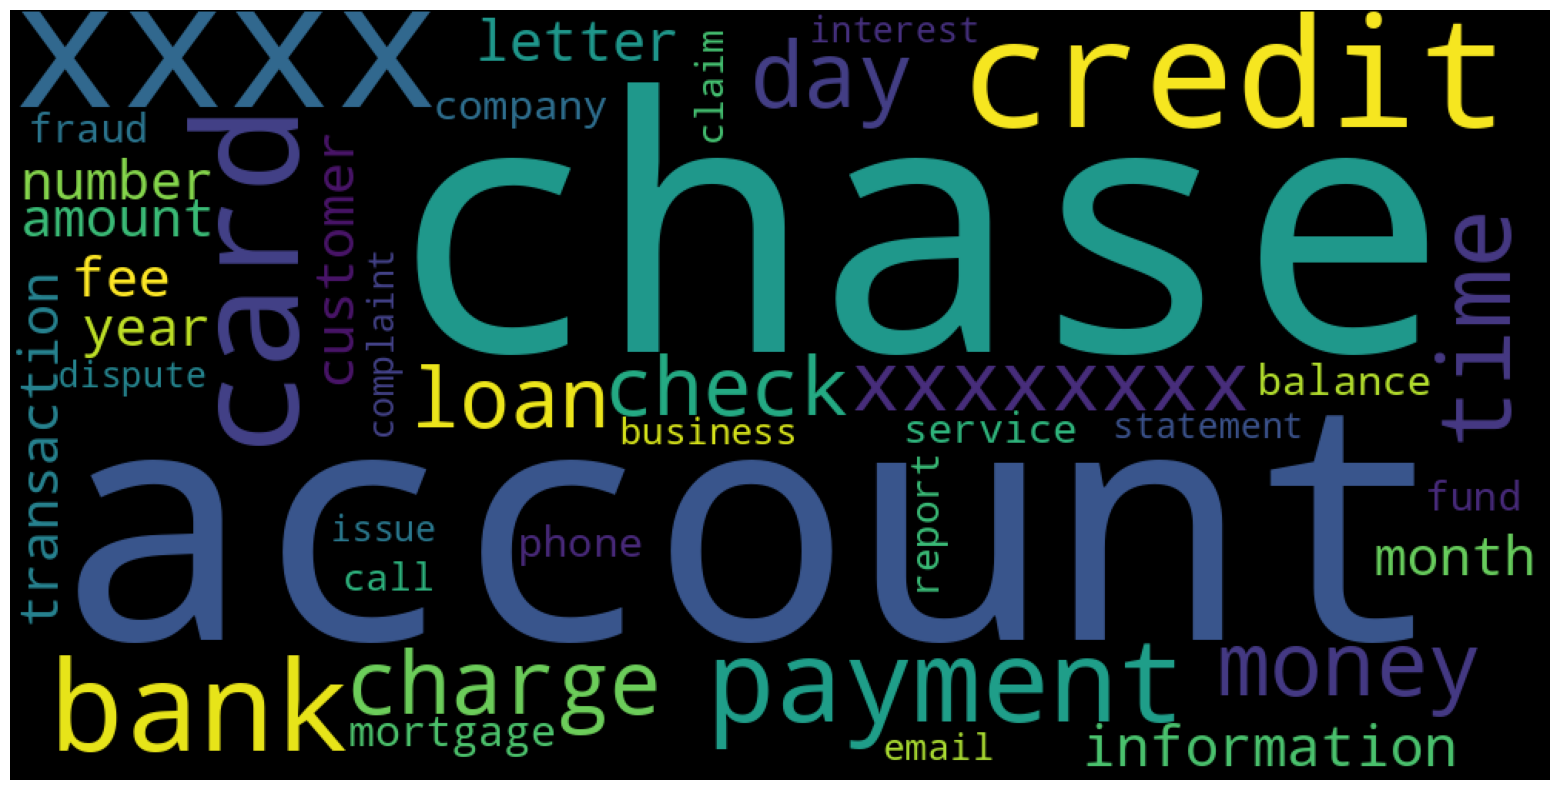

In [15]:
#Using a word cloud to find the top 40 words by frequency among all the articles after processing the text
word_cloud = WordCloud(collocations = False, width = 1000, height = 500, max_words = 40, random_state = 100).generate(" ".join(df_clean["pos_filtered_complaints"]))
plt.figure(figsize = (20, 10))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()



*   Words like transaction, credit, payment, account are highly frequent in the text corpus
*   Since chase is the company's name, it also has a high frequency of occurrence in the text corpus



All personal details of customers have been marked as xx...
Such masks are removed since they don't carry any information. The word "chase" has also been removed because it is the name of the company that is appearing in most of the complaints and doesn't carry any information

In [16]:
def xx_removal(complaint) :
  if re.search(r"\b[^\s]*x{2,}\b", complaint) :
    complaint = re.sub(r"\b[^\s]*x{2,}\b", "", complaint)
  if re.search(r"\bchase\b", complaint) :
    complaint = re.sub(r"\bchase\b", "", complaint)
  return complaint

df_clean["final_preprocessed_complaints"] = df_clean["pos_filtered_complaints"].apply(xx_removal)

In [17]:
df_clean.sample(5)

,raw_complaints,initial_preprocessed_complaints,lemmatized_complaints,pos_filtered_complaints,final_preprocessed_complaints
2572,fcra violation inquires from jpmcb hl is not mine please remove it showing late on mortgage was never late correct that showing utilization 100 on wireless bill that effects my score,fcra violation inquires from jpmcb hl is not mine please remove it showing late on mortgage was never late correct that showing utilization on wireless bill that effects my score,fcra violation inquire from jpmcb hl be not mine please remove it show late on mortgage be never late correct that show utilization on wireless bill that effect my score,violation mortgage utilization bill score,violation mortgage utilization bill score
1410,I am an ID Theft Victim and reported my consumer statement on XX/XX/2014 to advise the credit bureaus of my status and findings. The accounts below were part of this case however they continue to call me repeatedly and send me mail in an attempt to collect the debt. I advised this company of the situation however they persist in attempting to collect the debt and I am feeling harassed.,i am an id theft victim and reported my consumer statement on to advise the credit bureaus of my status and findings the accounts below were part of this case however they continue to call me repeatedly and send me mail in an attempt to collect the debt i advised this company of the situation however they persist in attempting to collect the debt and i am feeling harassed,I be an i d theft victim and report my consumer statement on to advise the credit bureaus of my status and finding the account below be part of this case however they continue to call I repeatedly and send I mail in an attempt to collect the debt I advise this company of the situation however they persist in attempt to collect the debt and I be feel harass,theft victim consumer statement credit bureaus status account part case mail attempt debt company situation debt,theft victim consumer statement credit bureaus status account part case mail attempt debt company situation debt
14245,"I applied for the XXXX XXXX Credit Card two weeks ago. On the site it offered a {$200.00} STATEMENT CREDIT after spending {$500.00} in the first three months. I applied for this card and was approved. Upon approval the page loaded and now said that I would receive a {$200.00} XXXX GIFT CARD. Normally, this would not have been much of a big deal to me but because we are going to XXXX in less than a month, the gift card would arrive too late for us to use at the park. Since, the promotion being advertised was NOT what I was being given I decided to call the company and ask them to uphold the offer that I had been promised when applying. I worked with them ( was told I 'd need to meet all requirements BEFORE they could submit anything for me ) and after meeting ALL of the requirements I called back and submitted a request to receive the promised {$200.00} as a statement credit. They sent the issue to their Advertising Dept. where it was rejected. I called back and this time asked to speak with a supervisor. This supervisor was VERY HELPFUL, he went to the site that I had applied for the card from, saw that I had in fact been offered a different promotion and told me that he would push it through and make sure that they "" did what they had promised. '' I felt assured that all would be resolved and waited. Then today I received another written notice that my request had been denied. I called and was informed by a supervisor that there was no other option for me to resolve this, that there was no one with more authority that I could speak with and no way for me to speak with someone in the department that rejected my claim. He told me there was nothing else that could be done regarding this situation and while I sat there in shock at being told that they would not continue to help me with this, he politely hung up on me. I can not believe that an established and trus

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [18]:
# Finding the top 30 unigram frequency among the complaints in the cleaned dataframe(df_clean)
count_vect = CountVectorizer(stop_words = "english", max_features = 5000)
count_matrix = count_vect.fit_transform(df_clean["final_preprocessed_complaints"])
idx = count_matrix.toarray().sum(axis = 0).argsort()[::-1][:30]
#unigram_freq = pd.DataFrame(count_matrix.toarray().sum(axis=0)[idx].reshape(-1, 1), columns=np.array(count_vect.get_feature_names_out())[idx])
feature_names = count_vect.get_feature_names_out().tolist()
unigram_freq = pd.DataFrame(
    count_matrix.toarray().sum(axis=0)[idx].reshape(-1, 1)
)
unigram_freq

,0
0,46178
1,32599
2,30231
3,21480
4,21157
5,16002
6,12972
7,11983
8,11955
9,10904


In [19]:
#Print the top 10 words in the unigram frequency
unigram_freq.iloc[0, :10].index

RangeIndex(start=0, stop=1, step=1)

In [20]:
#Finding the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
count_vect = CountVectorizer(stop_words = "english", ngram_range = (2, 2), max_features = 5000)
count_matrix = count_vect.fit_transform(df_clean["final_preprocessed_complaints"])
idx = count_matrix.toarray().sum(axis = 0).argsort()[::-1][:30]
feature_names1 = count_vect.get_feature_names_out().tolist()
bigram_freq = pd.DataFrame(
    count_matrix.toarray().sum(axis=0)[idx].reshape(-1, 1)
)
#bigram_freq = pd.DataFrame(count_matrix.toarray().sum(axis = 0)[idx].reshape(1, -1), columns = np.array(count_vect.get_feature_names())[idx])
bigram_freq

,0
0,12890
1,3848
2,3158
3,3068
4,2580
5,1960
6,1882
7,1827
8,1803
9,1775


In [21]:
#Print the top 10 words in the bigram frequency
bigram_freq.iloc[0, :10].index

RangeIndex(start=0, stop=1, step=1)

In [22]:
#Finding the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
count_vect = CountVectorizer(stop_words = "english", ngram_range = (3, 3), max_features = 5000)
count_matrix = count_vect.fit_transform(df_clean["final_preprocessed_complaints"])
idx = count_matrix.toarray().sum(axis = 0).argsort()[::-1][:30]
feature_names1 = count_vect.get_feature_names_out().tolist()
trigram_freq = pd.DataFrame(count_matrix.toarray().sum(axis = 0)[idx].reshape(1, -1))

#trigram_freq = pd.DataFrame(count_matrix.toarray().sum(axis = 0)[idx].reshape(1, -1), columns = np.array(count_vect.get_feature_names_out())[idx])
trigram_freq

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1051,1010,706,592,559,542,467,422,386,379,...,264,252,243,241,233,232,231,217,208,202


In [23]:
#Print the top 10 words in the trigram frequency
trigram_freq.iloc[0, :10].index

RangeIndex(start=0, stop=10, step=1)

### Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

In [24]:
# Initialising the TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = "english", ngram_range = (1, 3), max_features = 10000)

In [25]:
#Creating a document term matrix
document_term = vectorizer.fit_transform(df_clean["final_preprocessed_complaints"])

In [26]:
vocab = np.array(vectorizer.get_feature_names_out())
print("Vocabulary size :",len(vocab))

Vocabulary size : 10000


## Topic Modelling using NMF


In [27]:
from sklearn.decomposition import NMF

Choosing the number of topics as 3 and building an NMF model on the document_term matrix

In [28]:
num_topics = 3
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
             index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")

for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,transaction,day,branch,deposit,fee,claim,account account,number,fraud,bank account
Topic 2,card,credit,credit card,charge,report,credit report,inquiry,company,balance,card credit,dispute,account,score,letter,information
Topic 3,payment,loan,mortgage,home,modification,month,year,time,payment payment,property,rate,foreclosure,letter,mortgage payment,house




*  Topic 3 seems to be a valid topic
*  Topic 1 and 2 appear to be containing sub topics



Choosing the no of topics as 4 and repeating the process

In [29]:
num_topics = 4
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")
                                
for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,transaction,day,branch,deposit,account account,claim,fee,number,bank account,fraud
Topic 2,card,credit,credit card,charge,dispute,balance,purchase,company,service,time,card card,merchant,fraud,fee,card credit
Topic 3,payment,loan,mortgage,home,modification,month,year,time,payment payment,property,rate,foreclosure,mortgage payment,letter,house
Topic 4,inquiry,credit,report,credit report,inquiry credit,inquiry credit report,account,score,report credit,reporting,debt,information,account credit,credit report credit,identity




*   Topic 3 and 4 seem to be valid topics
*   Topic 1 and 2 seem to contain sub topics





Choosing the number of toics as 5 and repeating the process

In [30]:
num_topics = 5
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")
                                
for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,branch,deposit,account account,day,fee,bank account,checking,business,transaction,number
Topic 2,card,credit,credit card,balance,account,card credit,card card,card account,fee,score,limit,payment,year,month,credit card account
Topic 3,payment,loan,mortgage,home,modification,month,year,time,payment payment,property,rate,foreclosure,mortgage payment,house,letter
Topic 4,inquiry,report,credit,credit report,inquiry credit,inquiry credit report,information,report credit,reporting,debt,credit report credit,identity,credit inquiry,company,credit reporting
Topic 5,charge,dispute,transaction,merchant,claim,fraud,email,card,company,letter,service,time,purchase,information,phone





*   All are valid topics




Lets see if more topics can be extracted. 
Choosing the number of topics as 6 and repeating the process

In [31]:
num_topics = 6
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")
for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,money,account account,fee,fund,branch,checking,bank account,deposit,transaction,day,transfer,balance,checking account
Topic 2,card,credit,credit card,balance,card credit,card card,card account,score,limit,credit card credit,fee,year,month,payment,credit card account
Topic 3,payment,loan,mortgage,home,modification,month,year,time,payment payment,property,rate,foreclosure,mortgage payment,house,letter
Topic 4,inquiry,report,credit,credit report,inquiry credit,inquiry credit report,information,report credit,reporting,debt,credit report credit,credit inquiry,company,identity,credit reporting
Topic 5,charge,dispute,transaction,claim,merchant,fraud,email,card,company,time,service,letter,phone,information,purchase
Topic 6,check,bank,fund,check check,money,check account,check bank,deposit,day,account check,bank check,branch,hold,cashier,business




*   Topic 6 is a repeated topic



In [32]:
num_topics = 7
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")
for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,money,account account,fund,branch,fee,checking,bank account,transaction,deposit,day,number,transfer,checking account
Topic 2,card,credit,credit card,card credit,balance,card card,card account,score,limit,credit card credit,year,credit card account,card company,credit score,point
Topic 3,loan,mortgage,home,modification,property,year,rate,foreclosure,document,loan modification,time,house,sale,letter,debt
Topic 4,inquiry,report,credit,credit report,inquiry credit,inquiry credit report,report credit,information,reporting,credit report credit,credit inquiry,debt,company,identity,credit reporting
Topic 5,charge,dispute,transaction,merchant,claim,fraud,email,card,service,purchase,time,company,day,phone,charge charge
Topic 6,check,bank,fund,check check,check account,money,check bank,deposit,day,account check,bank check,branch,hold,cashier,business
Topic 7,payment,payment payment,balance,fee,month,statement,payment account,account payment,time,day,payment credit,payment month,auto,payment time,date




*   Topic 6 and 7 are repeated topics



Only 5 topics can be extracted from this dataset

In [33]:
num_topics = 5
nmf_model = NMF(n_components = num_topics, random_state = 40)
W = nmf_model.fit_transform(document_term)
H = nmf_model.components_

topic_top15words = pd.DataFrame(np.zeros((num_topics, 15)), columns = [f'Word {i+1}' for i in range(15)],
                                index = [f'Topic {i+1}' for i in range(num_topics)]).astype("str")
                                
for i in range(num_topics) :
  idx = H[i].argsort()[::-1][:15]
  topic_top15words.iloc[i] = vocab[idx]

topic_top15words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,branch,deposit,account account,day,fee,bank account,checking,business,transaction,number
Topic 2,card,credit,credit card,balance,account,card credit,card card,card account,fee,score,limit,payment,year,month,credit card account
Topic 3,payment,loan,mortgage,home,modification,month,year,time,payment payment,property,rate,foreclosure,mortgage payment,house,letter
Topic 4,inquiry,report,credit,credit report,inquiry credit,inquiry credit report,information,report credit,reporting,debt,credit report credit,identity,credit inquiry,company,credit reporting
Topic 5,charge,dispute,transaction,merchant,claim,fraud,email,card,company,letter,service,time,purchase,information,phone


Extracting the dominant topic from each complaint and assigning them an integer value (0, 1, 2, 3, 4)

In [34]:
document_topic = pd.DataFrame(W, columns = [f'Topic {i + 1}' for i in range(num_topics)])
document_topic["Dominant_Topic"] = document_topic.apply(lambda x : np.argmax(x), axis = 1)
document_topic.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Dominant_Topic
0,0.015593,0.002271,0.011991,0.010650,0.007787,0
1,0.007280,0.012532,0.003468,0.000758,0.009211,1
2,0.000000,0.035846,0.000000,0.019502,0.003414,1
3,0.014191,0.025240,0.003669,0.049245,0.006888,3
4,0.061621,0.000000,0.000000,0.000000,0.000000,0


In [35]:
df_clean['Topic'] = document_topic["Dominant_Topic"]
df_clean.sample(5)

,raw_complaints,initial_preprocessed_complaints,lemmatized_complaints,pos_filtered_complaints,final_preprocessed_complaints,Topic
7610,On the XXXX XXXX XXXX I tried to pay my balance on my credit card.I called the number listed. I heard about every 3rd w ord from the customer service person. I would like to add that making payments before due dates are not as straight forward as they need t o be .I 'm wond ering if this is not intentional. It should n't be that hard to pay your bills.,on the xxxx xxxx xxxx i tried to pay my balance on my credit cardi called the number listed i heard about every w ord from the customer service person i would like to add that making payments before due dates are not as straight forward as they need t o be i m wond ering if this is not intentional it should nt be that hard to pay your bills,on the xxxx xxxx xxxx I try to pay my balance on my credit cardi call the number list I hear about every w ord from the customer service person I would like to add that make payment before due date be not as straight forward as they need t o be I m wond ere if this be not intentional it should not be that hard to pay your bill,xxxx xxxx balance credit cardi number w ord customer service person payment date o bill,balance credit cardi number w ord customer service person payment date o bill,2
5774,I received another inquiry on my credit report that was not authorized. I am a victim of identity theft. I have a police report number for a report filed with the XXXX Police Department which is : XXXX This inquiry was not authorized by me. \n\nI have attached letters from other creditors showing their investigation results.,i received another inquiry on my credit report that was not authorized i am a victim of identity theft i have a police report number for a report filed with the xxxx police department which is xxxx this inquiry was not authorized by me \n\ni have attached letters from other creditors showing their investigation results,I receive another inquiry on my credit report that be not authorize I be a victim of identity theft I have a police report number for a report file with the xxxx police department which be xxxx this inquiry be not authorize by I \n\n I have attach letter from other creditor show their investigation result,inquiry credit report victim identity theft police report number report xxxx police department xxxx inquiry letter creditor investigation result,inquiry credit report victim identity theft police report number report police department inquiry letter creditor investigation result,3
13714,Chase has improperly withdrawn money from my XXXX checking account for payment to a Chase credit card that I share with my mom but have n't used in over 3 years. \nWe both have an online Chase account. She made a payment to the joint credit card from her online account. She nor I have ever verified my XXXX checking account on her online Chase account. I have verified it to XX/XX/XXXX payments to my other Chase credit cards. I believe they have a bug in their system that is authorizing her to withdrawn money from my XXXX account by allowing her access since I have already verified it on my online Chase account. \nChase will not fix the issue. \nMy mom is not computer savvy. She would not be able to confirm the two small deposits into my XXXX account to verified it online. She does not have access to any of my XXXX checks. She has her own money and has never called Chase to access the XXXX account. Chase will not further research this issue. I believe this must be an ongoing issue where Chase is withdrawing unauthorized funds from external bank accounts.,chase has improperly withdrawn money from my xxxx checking account for payment to a chase credit card that i share with my mom but have nt used in over years \nwe both have an online chase account she made a payment to the joint credit card from her online account she nor i have ever verified my xxxx checking account on her online chase account i have

Validate the documnet topic mapping

In [36]:
#Print the first 5 Complaint for each of the Topics  
df_clean.groupby('Topic').head(5).sort_values(by = "Topic")

,raw_complaints,initial_preprocessed_complaints,lemmatized_complaints,pos_filtered_complaints,final_preprocessed_complaints,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I be receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer chase account xxxx thank advance help,morning name stop bank cardmember service debt verification statement bank debt mail month debt right information consumer account thank advance help,0
10,mishandling of this account by Chase auto and XXXX.,mishandling of this account by chase auto and xxxx,mishandle of this account by chase auto and xxxx,account chase auto xxxx,account auto,0
6,"With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assured me that the funds would Post but they may take an additional business day. That Saturday I attempted to go inside of a branch yet again to retrieve my funds that actually did post on Friday, XX/XX/2019. Upon looking at my account I realize that the funds have been reversed and no longer were present on my current statement. Ive been called and I was told that it may take two business day stating Tuesday, XX/XX/XXXX would be the date that my funds would be available to withdraw from a bank teller only. Now, Chase is informing me that I will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently. Unfortunately, This has put me in an additional financial bind do two fees from late rent late car payments, etc. I am not being a short or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks suspicious after giving me a suspicious look myself. Although I know that Chase reserves the right to close my account at any time I do believe that their protocol has been in the past to give notice in the form of a written document. I am not being a shored or giving written notice that these things will actually occur so that I have peace of mind in fact Chase has handled my situation grossly I even had a bank teller inform me that my account looks

Assigning appropriate labels to topics

In [37]:
topic_idx_name_mapping = {0 : "Bank Account services", 1 : "Credit card/Prepaid card", 2 : "Mortgage/Loan", 3 : "Others", 4 : "Theft/Dispute Reporting"}
df_clean['Topic'] = df_clean['Topic'].map(topic_idx_name_mapping)
df_clean.sample(5)

,raw_complaints,initial_preprocessed_complaints,lemmatized_complaints,pos_filtered_complaints,final_preprocessed_complaints,Topic
5955,"Hello, I 'm typing this email because I need your help, Chase has placed me under a short sale since last yea r ( XXXX XXXX ). a buyer made an offer and after several months waiting for an approval Buyer decided to move on. <P/> So at that point we reach out to a back offer that was made and we submitted all documents. Chase told me that my application for a short sale will be reviewed with the new buyers offer. <P/> After 7 months now waiting for an approval, Chase now decides to deny my application because they could n't identify me. <P/> I was like what are you talking about??? Chase is now making excuses to foreclose on my home. I have asked them what do they need from me. <P/> Chase keeps telling me that they do n't have the details but my application for a short sale is denied. Now I 'm at risk of getting foreclosed on just because Chase is playing games. <P/> Please all I 'm asking is help to get this short sale completed, as it is I have to move out of the property and Chase keeps playing games with our home. <P/><P/> Thank you XXXX XXXX",hello i m typing this email because i need your help chase has placed me under a short sale since last yea r xxxx xxxx a buyer made an offer and after several months waiting for an approval buyer decided to move on p so at that point we reach out to a back offer that was made and we submitted all documents chase told me that my application for a short sale will be reviewed with the new buyers offer p after months now waiting for an approval chase now decides to deny my application because they could nt identify me p i was like what are you talking about chase is now making excuses to foreclose on my home i have asked them what do they need from me p chase keeps telling me that they do nt have the details but my application for a short sale is denied now i m at risk of getting foreclosed on just because chase is playing games p please all i m asking is help to get this short sale completed as it is i have to move out of the property and chase keeps playing games with our home pp thank you xxxx xxxx,hello I m type this email because I need your help chase have place I under a short sale since last yea r xxxx xxxx a buyer make an offer and after several month wait for an approval buyer decide to move on p so at that point we reach out to a back offer that be make and we submit all document chase tell I that my application for a short sale will be review with the new buyer offer p after month now wait for an approval chase now decide to deny my application because they could not identify I p I be like what be you talk about chase be now make excuse to foreclose on my home I have ask they what do they need from I p chase keep tell I that they do not have the detail but my application for a short sale be deny now I m at risk of get foreclose on just because chase be play game p please all I m ask be help to get this short sale complete as it be I have to move out of the property and chase keep playing game with our home pp thank you xxxx xxxx,email help chase sale r xxxx xxxx buyer offer month approval buyer p point back offer document chase application sale buyer p month approval chase application p chase excuse home p chase detail application sale risk chase game p help sale property chase playing game home xxxx,email help sale r buyer offer month approval buyer p point back offer document application sale buyer p month approval application p excuse home p detail application sale risk game p help sale property playing game home,Mortgage/Loan
11076,"on or about XXXX XXXX i purchased product online and unknowingly signed up for card. I paid for purchase but Chase card co. charged me XXXX bucks and now plus fees and interest, I AM NOT PAYING IT and I have told them so, I have cut up the card",on or about xxxx xxxx i purchased product online and unknowingly s

## Building a supervised model to predict the category of unseen complaints 

You have now build a model to create the topics for each complaint.Now in the below section you will use it to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers

In [38]:
topic_name_idx_mapping = {"Bank Account services" : 0, "Credit card/Prepaid card" : 1, "Mortgage/Loan" : 2 , "Others" : 3, "Theft/Dispute Reporting" : 4}
df_clean['Topic'] = df_clean['Topic'].map(topic_name_idx_mapping)
df_clean.sample(5)

,raw_complaints,initial_preprocessed_complaints,lemmatized_complaints,pos_filtered_complaints,final_preprocessed_complaints,Topic
20939,"I did reported to chase credit company that my credit card was stolen and being a fraud charge for {$720.00} to XXXX XXXX in XX/XX/XXXX. \n\nThe Chase company did closed my account and send me a new cared with a new credit number. \n\nThe amount XXXX dollars was clear at that time but it came back to my account at XX/XX/XXXX, I tried to call the Chase many times but nobody can resolve my problem.",i did reported to chase credit company that my credit card was stolen and being a fraud charge for to xxxx xxxx in xxxxxxxx \n\nthe chase company did closed my account and send me a new cared with a new credit number \n\nthe amount xxxx dollars was clear at that time but it came back to my account at xxxxxxxx i tried to call the chase many times but nobody can resolve my problem,I do report to chase credit company that my credit card be steal and be a fraud charge for to xxxx xxxx in xxxxxxxx \n\n the chase company do close my account and send I a new care with a new credit number \n\n the amount xxxx dollar be clear at that time but it come back to my account at xxxxxxxx I try to call the chase many time but nobody can resolve my problem,credit company credit card fraud charge chase company account credit number amount xxxx dollar time account chase time problem,credit company credit card fraud charge company account credit number amount dollar time account time problem,1
12226,I had this set up for auto pay. Every month I had to sit on phone for an hr to get it fixed or payed. It Was just for the fee they charge. I have called and had investigations done. All chase does is move the lates around from one month to the next. All my credit is 100 % pay on time for 20 year and more then 28 accounts. Funny I only have a problem with chase bank for two years. What was funny at the time I did the loan this bank said I was a XXXX credit!! Ok well 1 week later I thought I would refinance it and I had XXXX come back with a score of XXXX. Yes I know of the difference models but 120 points. This should be illegal! I took the truck and traded it off to get rid of Chase. Bank needs To be investigated for illegal charges and plus I never talked to a US person once to try and fix the problem. Not a good bank with all the complaints,i had this set up for auto pay every month i had to sit on phone for an hr to get it fixed or payed it was just for the fee they charge i have called and had investigations done all chase does is move the lates around from one month to the next all my credit is pay on time for year and more then accounts funny i only have a problem with chase bank for two years what was funny at the time i did the loan this bank said i was a xxxx credit ok well week later i thought i would refinance it and i had xxxx come back with a score of xxxx yes i know of the difference models but points this should be illegal i took the truck and traded it off to get rid of chase bank needs to be investigated for illegal charges and plus i never talked to a us person once to try and fix the problem not a good bank with all the complaints,I have this set up for auto pay every month I have to sit on phone for an hr to get it fix or pay it be just for the fee they charge I have call and have investigation do all chase do be move the late around from one month to the next all my credit be pay on time for year and more then account funny I only have a problem with chase bank for two year what be funny at the time I do the loan this bank say I be a xxxx credit ok well week later I think I would refinance it and I have xxxx come back with a score of xxxx yes I know of the difference model but point this should be illegal I take the truck and trade it off to get rid of chase bank need to be investigate for illegal charge and plus I never talk to a us person once to try and fix the problem not a good bank with all the com

Create a new dataframe containing the columns "final_preprocessed_complaints" and "Topic" from the df_clean dataframe

In [39]:
labelled_data = df_clean[["final_preprocessed_complaints", "Topic"]]
labelled_data.sample(5)

,final_preprocessed_complaints,Topic
18257,bank debit card purchasescheck order amount time account purchase result overdrawing account example girlfriend check share rent check account check girlfriend account purchase debit card delay processing check account fee check debit card payment overdrawing account example delay debit account statement atm withdrawal statement withdrawal statement account,0
16240,victim identity theft creditor account copy instrument account amount date card amount date credit amount date,3
5995,credit card account slate card program slate cc program amendment credit card freedom card year account account offer account transfer month slate card time balance answer transfer couple month account charge fee account help issue minimum issue,1
5930,credit card website bonus point month account opening screen shot offer spending month account bonus point bonus point month point bonus bonus point month account people messaging system problem system bait scam bonus point offer bonus point cfpb customer bonus bonus knowledge thank,1
16075,sir copy credit report credit bureaus item errorchase account number xxxxcredit card account account statement notification letter mail address information credit bureaus time letter error information item informationplease matter item,3


Splitting the labelled_data into train and test data

In [40]:
X_train, X_test, y_train, y_test = train_test_split(labelled_data["final_preprocessed_complaints"], labelled_data["Topic"], train_size = 0.75, stratify = labelled_data["Topic"], random_state = 100)

TF-IDF vectorizer is initialised and fit on the train data. It is then used to transform the train and test data into a document term matrix

In [41]:
#TF_IDF_vectorizer = TfidfVectorizer(stop_words = "english", ngram_range = (1, 3), max_df = 0.95, min_df = 2, max_features = 10000)
#X_train = TF_IDF_vectorizer.fit_transform(X_train.ravel()).toarray()
#X_test = TF_IDF_vectorizer.transform(X_test).toarray()
#print(len(TF_IDF_vectorizer.get_feature_names_out()))

TF_IDF_vectorizer = TfidfVectorizer(stop_words = "english", ngram_range = (1, 3), max_df = 0.95, min_df = 2, max_features = 10000)
X_train = TF_IDF_vectorizer.fit_transform(X_train.tolist()).toarray()
X_test = TF_IDF_vectorizer.transform(X_test.tolist()).toarray()
print(len(TF_IDF_vectorizer.get_feature_names_out()))


10000


Look at the class distribution of the target variable

In [42]:
y_train.value_counts()/len(y_train)

0    0.257909
2    0.237725
1    0.209820
4    0.194381
3    0.100165
Name: Topic, dtype: float64

### Modelling

Training a logistic regression model

In [43]:
model_1 = LogisticRegression(class_weight = "balanced", random_state = 100, max_iter = 500, n_jobs = -1)
model_1.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, n_jobs=-1,
                   random_state=100)

Defining a function to evalute all models

In [44]:
def model_evaluation(model) :
  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)
  print("Accuracy score on train data :", metrics.accuracy_score(y_train, y_train_pred))
  print("Accuracy score on test data :", metrics.accuracy_score(y_test, y_test_pred), end = "\n\n")
  print("Confusion matrix for test data :", metrics.confusion_matrix(y_test, y_test_pred), end = "\n\n", sep = "\n")
  print("Classification report on test data  :", metrics.classification_report(y_test, y_test_pred), sep = "\n")

Evaluating the logistic regression model

In [45]:
model_evaluation(model_1)

Accuracy score on train data : 0.9928499114148317
Accuracy score on test data : 0.964123006833713

Confusion matrix for test data :
[[1326    5    5    3   20]
 [   9 1053    0   14   29]
 [  13    7 1207   11   14]
 [   2    3    2  517    4]
 [  22   10   10    6  976]]

Classification report on test data  :
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1359
           1       0.98      0.95      0.96      1105
           2       0.99      0.96      0.97      1252
           3       0.94      0.98      0.96       528
           4       0.94      0.95      0.94      1024

    accuracy                           0.96      5268
   macro avg       0.96      0.97      0.96      5268
weighted avg       0.96      0.96      0.96      5268



Training a Naive Bayes Classifier

In [46]:
model_2 = MultinomialNB()
model_2.fit(X_train, y_train)

MultinomialNB()

Evaluating the Naive Bayes Classifier

In [47]:
model_evaluation(model_2)

Accuracy score on train data : 0.890027841052898
Accuracy score on test data : 0.8680713743356112

Confusion matrix for test data :
[[1273   27   35   13   11]
 [  43  945   16   14   87]
 [  42   52 1144    6    8]
 [   9   58   52  401    8]
 [ 117   49   46    2  810]]

Classification report on test data  :
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1359
           1       0.84      0.86      0.85      1105
           2       0.88      0.91      0.90      1252
           3       0.92      0.76      0.83       528
           4       0.88      0.79      0.83      1024

    accuracy                           0.87      5268
   macro avg       0.87      0.85      0.86      5268
weighted avg       0.87      0.87      0.87      5268



Training a  Decision Tree model

In [48]:
model_3 = DecisionTreeClassifier(class_weight = "balanced", random_state = 100)
model_3.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=100)

Evaluating the decision tree model

In [49]:
model_evaluation(model_3)

Accuracy score on train data : 1.0
Accuracy score on test data : 0.8323842065299925

Confusion matrix for test data :
[[1155   39   49   25   91]
 [  33  935   20   36   81]
 [  62   33 1090   23   44]
 [  16   40   21  440   11]
 [ 111   86   41   21  765]]

Classification report on test data  :
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1359
           1       0.83      0.85      0.84      1105
           2       0.89      0.87      0.88      1252
           3       0.81      0.83      0.82       528
           4       0.77      0.75      0.76      1024

    accuracy                           0.83      5268
   macro avg       0.83      0.83      0.83      5268
weighted avg       0.83      0.83      0.83      5268



Training a Random Forest Model

In [50]:
model_4 = RandomForestClassifier(random_state = 100, class_weight = "balanced", n_jobs = -1)
model_4.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=100)

Evaluating the random Forest Model

In [51]:
model_evaluation(model_4)

Accuracy score on train data : 1.0
Accuracy score on test data : 0.907744874715262

Confusion matrix for test data :
[[1281   37   17    7   17]
 [  27 1017   10   12   39]
 [  34   37 1163    8   10]
 [   8   22   14  479    5]
 [ 119   37   20    6  842]]

Classification report on test data  :
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1359
           1       0.88      0.92      0.90      1105
           2       0.95      0.93      0.94      1252
           3       0.94      0.91      0.92       528
           4       0.92      0.82      0.87      1024

    accuracy                           0.91      5268
   macro avg       0.91      0.90      0.91      5268
weighted avg       0.91      0.91      0.91      5268



Logistic regression model (model_1) is the better performing model

### Model Inference

Using the logistic regression model to predict the category of some arbitrary complaints

In [52]:
complaint = ["Not able to use my chase credit card for the past 3 days, for online purchasing. The card has not expired yet and I also have a good credit score. Please do look into this issue"]
print("The complaint falls into the category :", topic_idx_name_mapping.get(model_1.predict(TF_IDF_vectorizer.transform(complaint))[0]))

The complaint falls into the category : Credit card/Prepaid card


In [53]:
complaint = ["For the past 2 days i have been receiving email reminders to pay next month's installment but my mortgage has already been paid off. Why am I still receiving such messages?"]
print("The complaint falls into the category :", topic_idx_name_mapping.get(model_1.predict(TF_IDF_vectorizer.transform(complaint))[0]))

The complaint falls into the category : Mortgage/Loan
